In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
import numpy as np

save_dir = "../plots/lossy_compression/"

In [2]:
jpeg_stats_file = "../experimental_data/jpeg/stats.json"
balle_clic_stats_file = "../experimental_data/kodak_balle/stats.json"

In [3]:
!ls /scratch/gf332/models/relative-entropy-coding/lossy/clic2019/large_level_2_vae/mse/beta_0.010

checkpoint		      ckpt-665.index
ckpt-664.data-00000-of-00002  ckpt-666.data-00000-of-00002
ckpt-664.data-00001-of-00002  ckpt-666.data-00001-of-00002
ckpt-664.index		      ckpt-666.index
ckpt-665.data-00000-of-00002  kodak
ckpt-665.data-00001-of-00002  logs


In [47]:
base_dir = "/scratch/gf332/models/relative-entropy-coding/lossy/clic2019/large_level_2_vae/"

rec_kodak_stats_files = {
    "ms_ssim": {
        0.2: f"{base_dir}/ms-ssim/beta_0.010/kodak/results.csv",
        0.5: f"{base_dir}/ms-ssim/beta_0.030/kodak/results.csv",
        0.8: f"{base_dir}/ms-ssim/beta_0.050/kodak/results.csv",
        1.0: f"{base_dir}/ms-ssim/beta_0.080/kodak/results.csv",
    },
    "gaussian": {
        0.1: f"{base_dir}/mse/beta_0.003/kodak/results.csv",
        0.3: f"{base_dir}/mse/beta_0.010/kodak/results.csv",
        0.7: f"{base_dir}/mse/beta_0.030/kodak/results.csv",
        1.0: f"{base_dir}/mse/beta_0.050/kodak/results.csv",
    }
}

In [48]:
def plot_joint_statistics(joint_df, save_name, psnr=True, ms_ssim=True):

    sns.set(style="whitegrid")     
    paper_rc = {'lines.linewidth': 2, 'lines.markersize': 10}                  
    sns.set_context("paper", rc = paper_rc)  

    nrows = int(psnr) + int(ms_ssim)
    
    fig, axes = plt.subplots(nrows=nrows, figsize=(12, 8 * nrows))
    
    if not psnr or not ms_ssim:
        axes = np.array([axes])

    axes = axes.tolist()
        
    if psnr:
        ax = axes.pop()
        sns.lineplot(x="bpp", 
                     y="psnr", 
                     data=joint_df,
                     markers=True,
                     dashes=False,
                     hue='model', 
                     style='model',
                     ax=ax)

        ax.set_xlabel("BPP", fontsize=14)
        ax.set_ylabel("PSNR", fontsize=14)
        ax.tick_params(labelsize=12)
        ax.legend(fontsize=14)

    if ms_ssim:
        ax = axes.pop()
        sns.lineplot(x="bpp", 
                     y="ms_ssim", 
                     data=joint_df,
                     markers=True,
                     dashes=False,
                     hue='model', 
                     style='model',
                     ax=ax)

        ax.set_xlabel("BPP", fontsize=14)
        ax.set_ylabel("MS-SSIM", fontsize=14)
        ax.tick_params(labelsize=12)
        ax.legend(fontsize=14)

    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle(f"{save_name} Reconstruction Comparison", fontsize=16)

    fig.savefig(f"{save_dir}/{save_name}")

In [67]:
with open(jpeg_stats_file, 'r') as f:
    jpeg_df = pd.read_json(f)
    
with open(balle_clic_stats_file, 'r') as f:
    balle_df = pd.read_json(f)
    balle_df = balle_df.rename(lambda x: x[1:], axis=1)
    
    
gaussian_rec_dfs = []
ms_ssim_rec_dfs = []

for gauss_rec_bpp in sorted(rec_kodak_stats_files["gaussian"].keys()):
    
    with open(rec_kodak_stats_files["gaussian"][gauss_rec_bpp], 'r') as f:
        rec_df = pd.read_csv(f, sep=',\s+')

        rec_df = rec_df.T

        rec_df.columns = rec_df.iloc[0]

        rec_df = rec_df.drop(rec_df.index[0])
        
        rec_df.loc["loss"] = "gaussian"
        
        rec_df.loc["target_bpp"] = gauss_rec_bpp
        
        gaussian_rec_dfs.append(rec_df)
        
for ms_ssim_rec_bpp in sorted(rec_kodak_stats_files["ms_ssim"].keys()):
    
    with open(rec_kodak_stats_files["ms_ssim"][ms_ssim_rec_bpp], 'r') as f:
        rec_df = pd.read_csv(f, sep=',\s+')

        rec_df = rec_df.T

        rec_df.columns = rec_df.iloc[0]

        rec_df = rec_df.drop(rec_df.index[0])
        
        rec_df.loc["loss"] = "ms_ssim"
        
        rec_df.loc["target_bpp"] = ms_ssim_rec_bpp
        
        ms_ssim_rec_dfs.append(rec_df)

/scratch/gf332/CWOQ/relative-entropy-coding/rec-venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  from ipykernel import kernelapp as app
/scratch/gf332/CWOQ/relative-entropy-coding/rec-venv/lib/python3.7/site-packages/ipykernel_launcher.py:32: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


# Aggregate Statistics

In [50]:
balle_psnr_avg_df = pd.concat([pd.read_json(balle_df.T[model_name].to_json()).T.mean()
                    for model_name in balle_df.index], axis=1)

balle_psnr_avg_df = balle_psnr_avg_df.rename({i: model_name for i, model_name in enumerate(balle_df.index)}, 
                                             axis=1)

balle_psnr_avg_df = balle_psnr_avg_df.reindex(sorted(balle_psnr_avg_df.columns, 
                                      key=lambda c: float(f"0.{c.split('_')[1]}")), axis=1)

balle_psnr_avg_df.loc["model"] = "balle"

In [51]:
def get_rec_psnr_average_df(rec_dfs, kind):
    aggregate_df = pd.concat(rec_dfs, axis=1)
    aggregate_df = aggregate_df.T.astype({
        "comp_lossy_BPP": float,
        "lossy_BPP": float,
        "ideal_PSNR": float,
        "PSNR": float,
        "ideal_MS_SSIM": float,
        "MS_SSIM": float,
    })

    psnr_avg_df = aggregate_df.groupby("target_bpp").mean().rename({"PSNR": "psnr",
                                                                 "comp_lossy_BPP": "bpp",
                                                                 "MS_SSIM": "ms_ssim"}, axis=1)
    psnr_avg_df["model"] = f"rec-{kind}"

    ideal_psnr_avg_df = aggregate_df.groupby("target_bpp").mean().rename({"ideal_PSNR": "psnr",
                                                                 "lossy_BPP": "bpp",
                                                                 "ideal_MS_SSIM": "ms_ssim"}, axis=1)
    ideal_psnr_avg_df["model"] = f"ideal-rec-{kind}"
    
    return psnr_avg_df, ideal_psnr_avg_df

In [68]:
rec_gaussian_psnr_avg_df, ideal_rec_gaussian_psnr_avg_df = get_rec_psnr_average_df(gaussian_rec_dfs, "gaussian")
rec_ms_ssim_psnr_avg_df, ideal_rec_ms_ssim_psnr_avg_df = get_rec_psnr_average_df(ms_ssim_rec_dfs, "ms_ssim")

In [69]:
joint_psnr_avg_df = pd.concat([balle_psnr_avg_df,
                               rec_gaussian_psnr_avg_df.T,
                               ideal_rec_gaussian_psnr_avg_df.T,
                               rec_ms_ssim_psnr_avg_df.T,
                               ideal_rec_ms_ssim_psnr_avg_df.T], axis=1).T.astype({"bpp": float,
                                                                    "psnr": float,
                                                                    "ms_ssim": float})
joint_psnr_avg_df['ms_ssim'] = -10 * np.log10(1 - joint_psnr_avg_df['ms_ssim'])

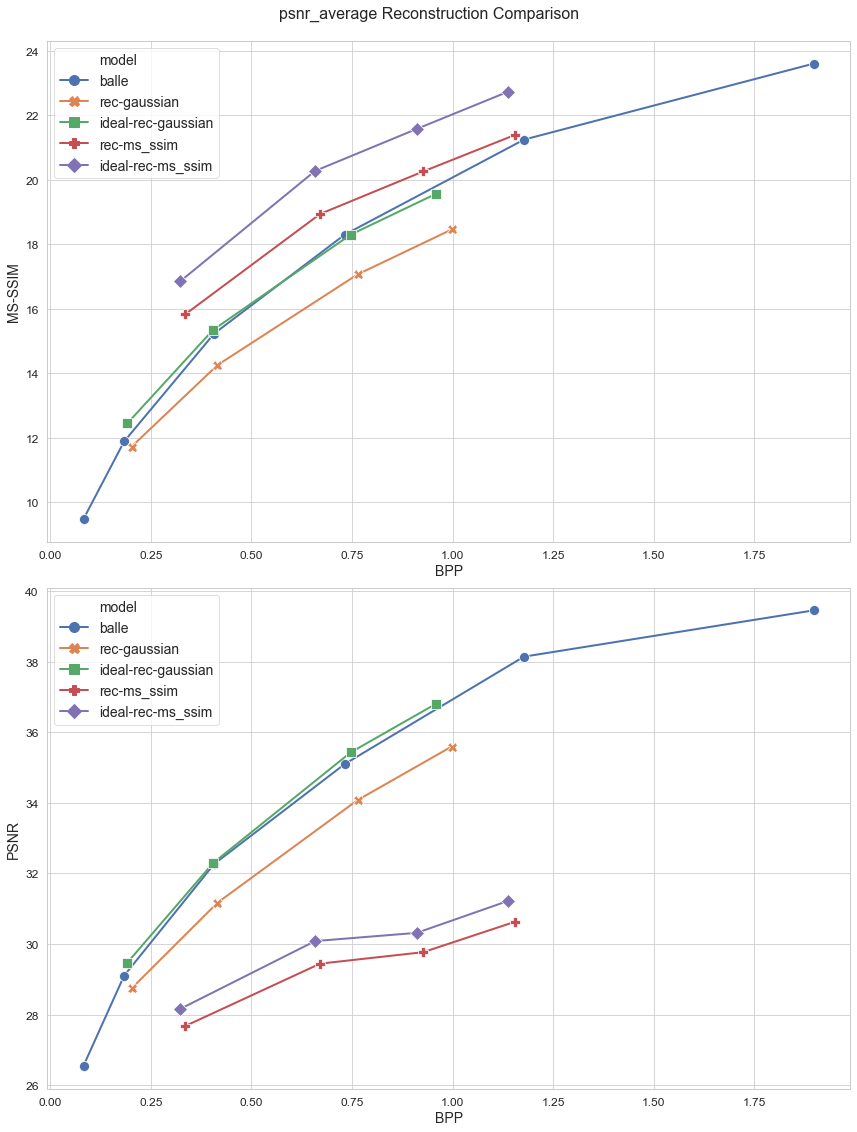

In [78]:
plot_joint_statistics(joint_psnr_avg_df, "psnr_average", ms_ssim=True)

In [55]:
def interpolate_balle_bpp(image_name):
    image_df = pd.read_json(balle_df[image_name].to_json())
    image_df = image_df.reindex(sorted(image_df.columns, 
                            key=lambda c: float(f"0.{c.split('_')[1]}")), axis=1).T

    orig_bpp = image_df['bpp'].values
    indices = np.concatenate([np.arange(0.05, 2.15, 0.05), image_df['bpp'].values], axis=0)
    indices = np.sort(indices)
    return image_df.set_index('bpp').reindex(indices).interpolate(method='cubic').dropna().drop(orig_bpp.tolist())

balle_interpolated = pd.concat([interpolate_balle_bpp(img_name) for img_name in balle_df.columns], axis=0)

balle_ms_ssim_avg_df = balle_interpolated.groupby('bpp').aggregate({"ms_ssim": np.mean}).reset_index()
balle_ms_ssim_avg_df["model"] = "balle"

In [71]:
def get_rec_ms_ssim_average(rec_dfs, kind, method="cubic"):

    aggregate_df = pd.concat(rec_dfs, axis=1)
    aggregate_df = aggregate_df.T.astype({
        "comp_lossy_BPP": float,
        "lossy_BPP": float,
        "ideal_PSNR": float,
        "PSNR": float,
        "ideal_MS_SSIM": float,
        "MS_SSIM": float,
    })
    
    def interpolate_rec_bpp(image_name, index):
        image_df = aggregate_df.loc[image_name][["comp_lossy_BPP", 
                                                 "lossy_BPP",
                                                 "ideal_PSNR",
                                                 "PSNR",
                                                 "ideal_MS_SSIM",
                                                 "MS_SSIM"]]
        orig_bpp = image_df[index].values
        indices = np.concatenate([np.arange(0.05, 1.5, 0.05), image_df[index].values], axis=0)
        indices = np.sort(indices)

        # TODO: use cubic when more datapoints are available
        return image_df.set_index(index).reindex(indices).interpolate(method=method).dropna().drop(orig_bpp.tolist())

    interpolated = pd.concat([interpolate_rec_bpp(img_name, "comp_lossy_BPP") 
                              for img_name in sorted(set(aggregate_df.index))]).reset_index()
    
    ideal_interpolated = pd.concat([interpolate_rec_bpp(img_name, "lossy_BPP") 
                                    for img_name in sorted(set(aggregate_df.index))]).reset_index()

    avg_df = interpolated.rename({
         "PSNR": "psnr",
         "comp_lossy_BPP": "bpp",
         "MS_SSIM": "ms_ssim"
    }, axis=1).groupby('bpp').aggregate({"ms_ssim": np.mean}).reset_index()

    avg_df["model"] = f"rec-{kind}"

    ideal_avg_df = ideal_interpolated.rename({
         "ideal_PSNR": "psnr",
         "lossy_BPP": "bpp",
         "ideal_MS_SSIM": "ms_ssim"
    }, axis=1).groupby('bpp').aggregate({"ms_ssim": np.mean}).reset_index()

    ideal_avg_df["model"] = f"ideal-rec-{kind}"
    
    return avg_df, ideal_avg_df

In [75]:
gaussian_rec_ms_ssim_avg_df, ideal_gaussian_rec_ms_ssim_avg_df = get_rec_ms_ssim_average(gaussian_rec_dfs, "gaussian")
ms_ssim_rec_ms_ssim_avg_df, ideal_ms_ssim_rec_ms_ssim_avg_df = get_rec_ms_ssim_average(ms_ssim_rec_dfs, "ms_ssim")

In [76]:
joint_ms_ssim_avg_df = pd.concat([balle_ms_ssim_avg_df, 
                                  gaussian_rec_ms_ssim_avg_df,
                                  ideal_gaussian_rec_ms_ssim_avg_df,
                                  ms_ssim_rec_ms_ssim_avg_df,
                                  ideal_ms_ssim_rec_ms_ssim_avg_df], axis=0).astype({"bpp": float,
                                                                         "ms_ssim": float})
joint_ms_ssim_avg_df['ms_ssim'] = -10 * np.log10(1 - joint_ms_ssim_avg_df['ms_ssim'])

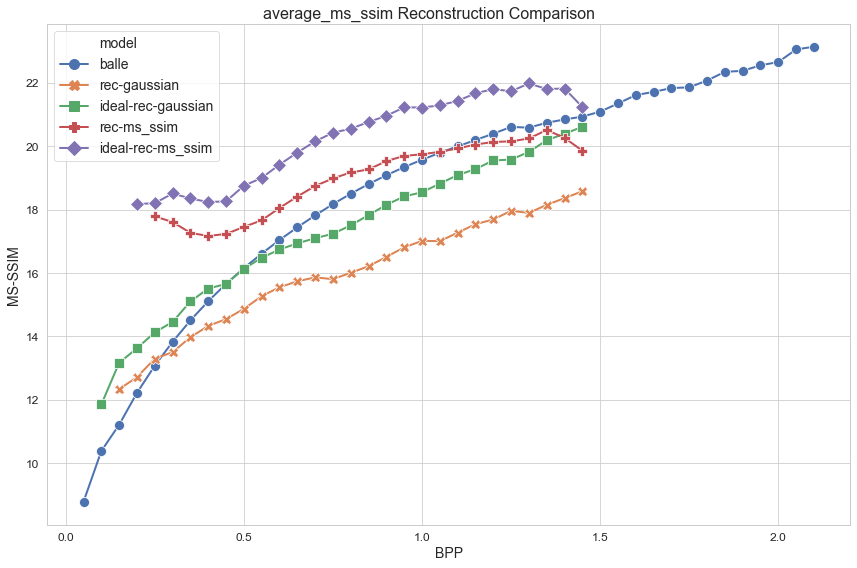

In [77]:
plot_joint_statistics(joint_ms_ssim_avg_df, "average_ms_ssim", psnr=False)

# Individual Images

In [8]:
img_name = 'kodim11.png'

jpeg_img_df = pd.read_json(jpeg_df[img_name].to_json())
balle_img_df = pd.read_json(balle_df[img_name].to_json())

jpeg_img_df.loc["model"] = "jpeg"
balle_img_df.loc["model"] = "balle"

# Put the columns in order
jpeg_img_df = jpeg_img_df.reindex(sorted(jpeg_img_df.columns, key=lambda c: int(c.split('_')[1])), axis=1)
balle_img_df = balle_img_df.reindex(sorted(balle_img_df.columns, 
                                           key=lambda c: float(f"0.{c.split('_')[1]}")), axis=1)

ideal_rec_df = pd.DataFrame(rec_df[img_name].apply(float))
actual_rec_df = ideal_rec_df.copy()

ideal_rec_df = ideal_rec_df.rename({"ideal_PSNR": "psnr",
                                    "lossy_BPP": "bpp",
                                    "ideal_MS_SSIM": "ms_ssim"}).loc[["psnr", "bpp", "ms_ssim"]]

actual_rec_df = actual_rec_df.rename({"PSNR": "psnr",
                                     "comp_lossy_BPP": "bpp",
                                     "MS_SSIM": "ms_ssim"}).loc[["psnr", "bpp", "ms_ssim"]]

ideal_rec_df.loc["model"] = "ideal_rec"
actual_rec_df.loc["model"] = "actual_rec"

In [9]:
joint_df = pd.concat([jpeg_img_df, 
                      balle_img_df, 
                      ideal_rec_df, 
                      actual_rec_df], axis=1).T.astype({"bpp": float,
                                                        "psnr": float,
                                                        "ms_ssim": float})

In [10]:
# Convert MS-SSIM statistic to decibels
joint_df['ms_ssim'] = -10 * np.log(1 - joint_df['ms_ssim'])

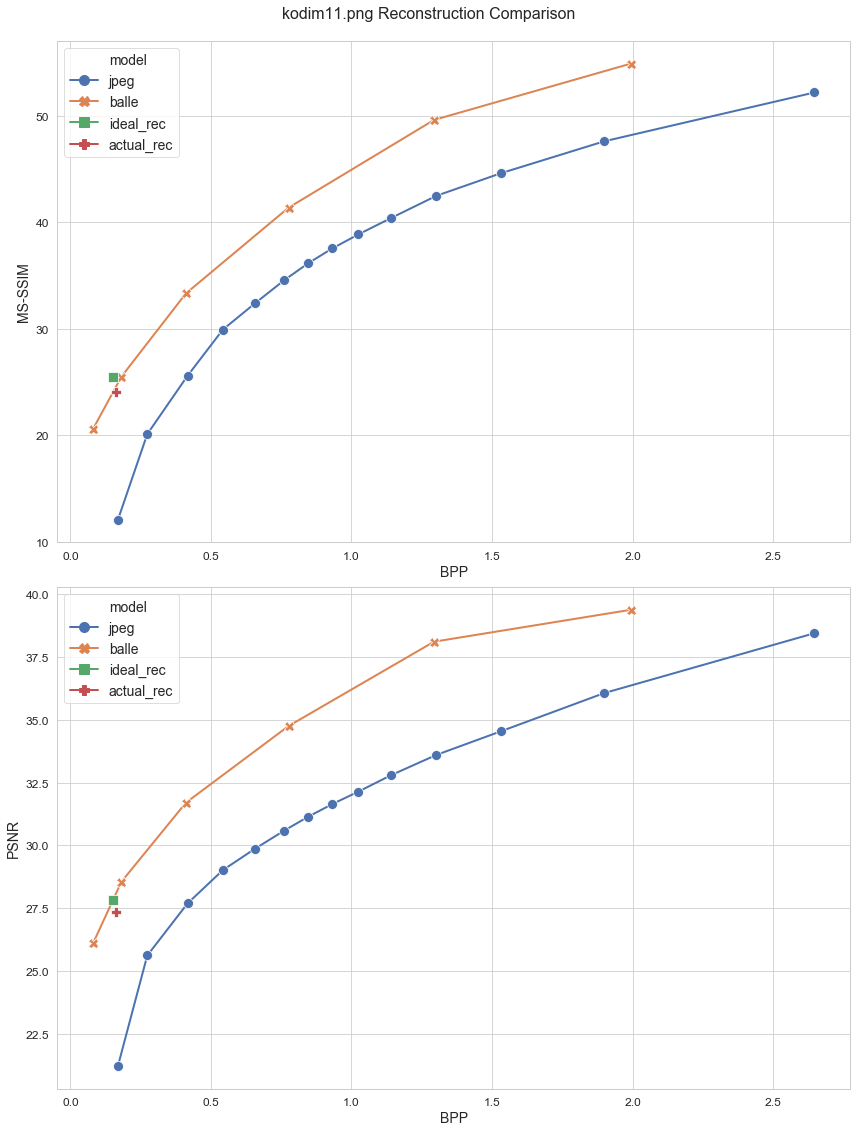

In [20]:
plot_joint_statistics(joint_df, img_name, psnr=True)